# Aprendizaje supervisado

# Definición de métrica objetivo

En este caso de estudio, dado que nuestra variable a predecir se trata de la variable binaria **is_canceled** la cual determina si una reserva a sido o no cancelada, crremos que la metrica a maximizar es la **Accuracy**

La accuracy de un algoritmo de clasificación de aprendizaje automático es una forma de medir la frecuencia con la que el algoritmo clasifica correctamente. La accuracy es el número de datos predichos correctamente de entre todos los datos. Más formalmente, se define como el número de verdaderos positivos y verdaderos negativos dividido por el número de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos. 

Un verdadero positivo o un verdadero negativo es un dato que el algoritmo clasificó correctamente como verdadero o falso, respectivamente. Un falso positivo o un falso negativo, por el contrario, es un punto de datos que el algoritmo clasificó incorrectamente. 

La definicion en si misma de la accuracy se ajusta a nuestras necesidades, pues considerados más importante acertar la cancelación de la reserva, pues un falso positivo podría producir que el hospedador prereservara la habitación, o errores muy graves en la actualidad como posponer una desinfección de la habitación, pues el sistema le reporte un falso positivo.


## 1. Librerias

In [1]:
import pandas as pd
import numpy as np
import io
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
warnings.filterwarnings('ignore')
import random
random.seed(1)
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

## 2. Datos

Vamos a realizar el proceso con dos selección de variables distintas para ver con cual obtenemos mejores resultados:

* Selección 1: Las 25 variables más importantes obtenidas en el apartado de "Selección de Variables" del primer trimestre.

* Selección 2: Formada por las variables arrival_month, deposit_type_Non Refund, is_repeated_guest, reserverd/assigned, hotel_Resort Hotel.

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,deposit_type_Non Refund,deposit_type_Refundable,reserverd/assigned,customer_type_Group,customer_type_Transient-Party
0,0,0.0,13.077658,2015.0,27.0,1.0,2.0,5.0,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,7.389493,2015.0,27.0,1.0,0.0,2.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2,0.0,7.755577,2015.0,27.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,3,0.0,13.077658,2015.0,27.0,1.0,0.0,4.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1.0,7.389493,2015.0,27.0,1.0,0.0,2.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Selección de datos 1

In [3]:
X1 = data.iloc[:,2:30].values
Y1 = data.iloc[:,1].values

In [4]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.33, random_state=1)
print('Train', X_train1.shape, y_train1.shape)
print('Test', X_test1.shape, y_test1.shape)

Train (20100, 28) (20100,)
Test (9900, 28) (9900,)


### Selección de datos 2

In [5]:
#Vars selected
vars_s=['arrival_month','deposit_type_Non Refund','is_repeated_guest','reserverd/assigned','hotel_Resort Hotel']

Y2 = data.is_canceled
X2 = data[vars_s]

In [6]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.33, random_state=1)
print('Train', X_train2.shape, y_train2.shape)
print('Test', X_test2.shape, y_test2.shape)

Train (20100, 5) (20100,)
Test (9900, 5) (9900,)


## 3. Regresion Logística

Mediante la RL se pretende modelar la probabilidad de que ocurra el hecho en cuestión como función de ciertas variables que se presumen relevantes o influyentes. Por lo tanto, la RL consiste en obtener una función logística de las variables independientes que permita clasificar a los individuos en una de las dos subpoblaciones o grupos establecidos por los dos va­lores de la variable dependiente.

La función logística es aquella que halla, para cada individuo según los valores de una serie de variables (Xi), la probabilidad (p) de que presente el efecto estudiado. Una transformación logarítmica de dicha ecuación, a la que se le llama logit. De aquí surge la ecuación de la regresión logística, que es parecida a la ecuación de la regresión lineal múltiple.

In [7]:
def evaluate_model(X_train, y_train,X_test, y_test, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    diff = scores.mean() - model.score(X_test, y_test)
    SD = diff / scores.std()
    
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(f"Standard Deviations Away: {SD}")
    print(confusion_matrix(y_test, preds))
   
    print(classification_report(y_test, preds))
    
    logit_roc_auc = roc_auc_score(y_test, preds)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Balanceado

Para el balanceado de los datos utilizaremos la tecnica SMOTE (Synthetic Minority Oversampling Technique).

SMOTE es una técnica estadística de sobremuestreo de minorías sintéticas para aumentar el número de casos de un conjunto de datos de forma equilibrada. El módulo funciona cuando genera nuevas instancias a partir de casos minoritarios existentes que se proporcionan como entrada. SMOTE no cambia el número de casos de mayoría.

Las instancias nuevas no son meras copias de los casos minoritarios existentes. En su lugar, el algoritmo toma muestras del espacio de características de cada clase de destino y de sus vecinos más próximos. Luego, el algoritmo genera nuevos ejemplos que combinan las características del caso que nos ocupa con características de sus vecinos. Este enfoque aumenta las características disponibles para cada clase y hace que las muestras sean más generales.

In [8]:
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train1, y_train1)
os_data_2X,os_data_2y=os.fit_sample(X_train2, y_train2)

### Selección de datos 1

Training Score:0.928385107896609
Cross V Score: 0.9276737016836614 +/- 0.008534129491293148
Testing Score: 0.9281818181818182
Cross & Test Diff: -0.000508116498156852
Standard Deviations Away: -0.05953934712090463
[[5955  343]
 [ 368 3234]]
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      6298
         1.0       0.90      0.90      0.90      3602

    accuracy                           0.93      9900
   macro avg       0.92      0.92      0.92      9900
weighted avg       0.93      0.93      0.93      9900



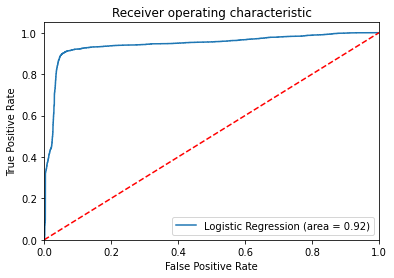

In [9]:
reg_log = LogisticRegression(random_state=0, solver='newton-cg', max_iter=1000)
evaluate_model(os_data_X, os_data_y, X_test1, y_test1, reg_log)

### Selección de datos 2

Training Score:0.6611730298000158
Cross V Score: 0.6611730298000159 +/- 0.0031105038921746837
Testing Score: 0.7540404040404041
Cross & Test Diff: -0.09286737424038816
Standard Deviations Away: -29.85605466497606
[[6289    9]
 [2426 1176]]
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84      6298
         1.0       0.99      0.33      0.49      3602

    accuracy                           0.75      9900
   macro avg       0.86      0.66      0.66      9900
weighted avg       0.82      0.75      0.71      9900



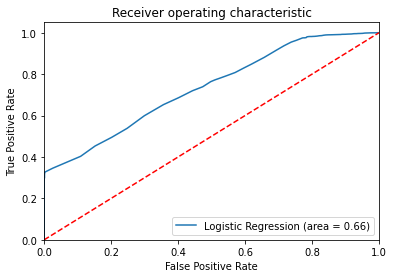

In [10]:
reg_log = LogisticRegression(random_state=0, solver='newton-cg', max_iter=1000)
evaluate_model(os_data_2X, os_data_2y, X_test2, y_test2, reg_log)

## 4. KNN

El algoritmo KNN (K Nearest Neighbours) clasifica cada dato nuevo en el grupo que corresponda, según tenga k vecinos más cerca de un grupo o de otro. Es decir, calcula la distancia del elemento nuevo a cada uno de los existentes, y ordena dichas distancias de menor a mayor para ir seleccionando el grupo al que pertenecer. Este grupo será, por tanto, el de mayor frecuencia con menores distancias.

En contraste con otros algoritmos de aprendizaje supervisado, K-NN no genera un modelo fruto del aprendizaje con datos de entrenamiento, sino que el aprendizaje sucede en el mismo momento en el que se prueban los datos de test. A este tipo de algoritmos se les llama lazy learning methods.

### Selección de datos 1

In [11]:
X_train = X_train1
y_train = y_train1

X_test = X_test1
y_test = y_test1

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

Primero estandarizamos los valores.

Ahora vamos a buscar cual es el valor de K más óptimo.

In [13]:
error = []

for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_stand, y_train)
    pred_i = knn.predict(X_test_stand)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

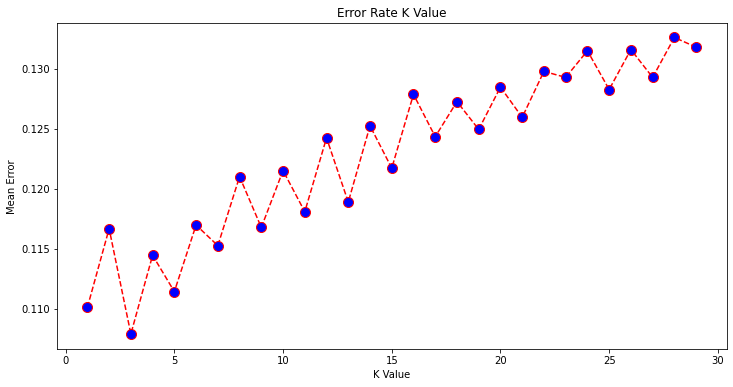

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Nos quedamos con K = 3 para entrenar el modelo.

In [15]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train_stand, y_train)

KNeighborsClassifier(n_neighbors=3)

In [16]:
y_pred = classifier.predict(X_test_stand)

Sacamos el informe de clasificación que hemos obtenido:

In [17]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5919  379]
 [ 689 2913]]
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      6298
         1.0       0.88      0.81      0.85      3602

    accuracy                           0.89      9900
   macro avg       0.89      0.87      0.88      9900
weighted avg       0.89      0.89      0.89      9900



De esta forma obtenemos una precisión de 90% para la clase no cancelado y 88% para cancelado con un recall de 94% y 80% respectivamente.
Lo que significa que encontramos el 80% de casos en los que se cancela la reserva, y predecimos correctamente el 90% de esos.
Esto da un f1-score de 92% y 85% respectivamente.

(El recall nos indica el porcentaje encontrado de esa clase con respecto a todos los elementos de esa misma clase)

### Selección de datos 2

In [18]:
X_train = X_train2
y_train = y_train2

X_test = X_test2
y_test = y_test2

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

Primero estandarizamos los valores.

Ahora vamos a buscar cual es el valor de K más óptimo.

In [20]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_stand, y_train)
    pred_i = knn.predict(X_test_stand)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

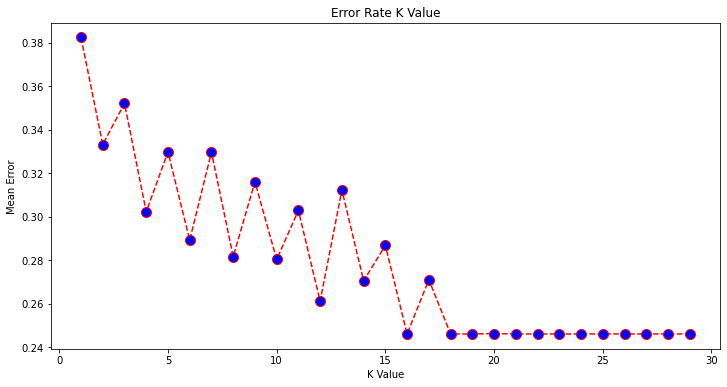

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Vemos que a partir de K = 16 el valor no se mejora, por lo que nos quedamos con ese valor para K.

In [22]:
classifier = KNeighborsClassifier(n_neighbors=16)
classifier.fit(X_train_stand, y_train)

KNeighborsClassifier(n_neighbors=16)

In [23]:
y_pred = classifier.predict(X_test_stand)

Sacamos el informe de clasificación que hemos obtenido:

In [24]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6277   21]
 [2415 1187]]
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84      6298
         1.0       0.98      0.33      0.49      3602

    accuracy                           0.75      9900
   macro avg       0.85      0.66      0.67      9900
weighted avg       0.82      0.75      0.71      9900



Con esta selección de variables obtenemos más precisión en cada una de las clases, pero un recall mucho más bajo, por lo que no está encontrado todos los elementos de la clase correspondiente.

Concluimos por lo tanto que se obtienen mejores resultados con la primera selección de datos, donde podemos decir sacamos un buen resultado.

## 5. SVM

El método de clasificación-regresión Máquinas de Vector Soporte (Vector Support Machines, SVMs) fue desarrollado en la década de los 90, dentro de campo de la ciencia computacional. Si bien originariamente se desarrolló como un método de clasificación binaria, su aplicación se ha extendido a problemas de clasificación múltiple y regresión. SVMs ha resultado ser uno de los mejores clasificadores para un amplio abanico de situaciones, por lo que se considera uno de los referentes dentro del ámbito de aprendizaje estadístico y machine learning.

Las Máquinas de Vector Soporte se fundamentan en el Maximal Margin Classifier, que a su vez, se basa en el concepto de hiperplano.

Las ventajas de las máquinas de vectores de soporte son:
* Eficaces en espacios de gran dimensión. Siguen siendo eficaces en los casos en que el número de dimensiones es mayor que el número de muestras.
* Utiliza un subconjunto de puntos de entrenamiento en la función de decisión (llamados vectores de soporte), por lo que también es eficiente en la memoria.
* Versátil: se pueden especificar diferentes funciones kernel para la función de decisión. Se proporcionan kernels comunes en sklearn, pero también es posible especificar kernels personalizados.

Las desventajas de las máquinas de vectores de soporte incluyen:
* Si el número de características es mucho mayor que el número de muestras, evitar el ajuste excesivo es crucial al elegir las funciones del Kernel y el término de regularización.
* Las SVM no proporcionan directamente estimaciones de probabilidad.

In [25]:
def launch_SVM(X_train,y_train,X_test,y_test,kernel='linear'):
    svc = SVC(kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    confusion_matrix(y_test, y_pred)
    print('---Matriz de confusión---')
    print()
    print(confusion_matrix(y_test,y_pred))
    print()
    print('---Report---')
    print(classification_report(y_test1,y_pred))

### Selección de datos 1

#### Kernel lineal

In [26]:
launch_SVM(X_train1,y_train1,X_test1,y_test1,kernel='linear')

---Matriz de confusión---

[[6027  271]
 [ 459 3143]]

---Report---
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      6298
         1.0       0.92      0.87      0.90      3602

    accuracy                           0.93      9900
   macro avg       0.92      0.91      0.92      9900
weighted avg       0.93      0.93      0.93      9900



#### Kernel Gaussiano

In [27]:
launch_SVM(X_train1,y_train1,X_test1,y_test1,kernel='rbf')

---Matriz de confusión---

[[6296    2]
 [3601    1]]

---Report---
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78      6298
         1.0       0.33      0.00      0.00      3602

    accuracy                           0.64      9900
   macro avg       0.48      0.50      0.39      9900
weighted avg       0.53      0.64      0.49      9900



#### Kernel Sigmoide

In [28]:
launch_SVM(X_train1,y_train1,X_test1,y_test1,kernel='sigmoid')

---Matriz de confusión---

[[6298    0]
 [3602    0]]

---Report---
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78      6298
         1.0       0.00      0.00      0.00      3602

    accuracy                           0.64      9900
   macro avg       0.32      0.50      0.39      9900
weighted avg       0.40      0.64      0.49      9900



### Selección de datos 2

#### Kernel lineal

In [29]:
launch_SVM(X_train2,y_train2,X_test2,y_test2,kernel='linear')

---Matriz de confusión---

[[6289    9]
 [2426 1176]]

---Report---
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84      6298
         1.0       0.99      0.33      0.49      3602

    accuracy                           0.75      9900
   macro avg       0.86      0.66      0.66      9900
weighted avg       0.82      0.75      0.71      9900



#### Kernel Gaussiano

In [30]:
launch_SVM(X_train2,y_train2,X_test2,y_test2,kernel='rbf')

---Matriz de confusión---

[[6289    9]
 [2426 1176]]

---Report---
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84      6298
         1.0       0.99      0.33      0.49      3602

    accuracy                           0.75      9900
   macro avg       0.86      0.66      0.66      9900
weighted avg       0.82      0.75      0.71      9900



#### Kernel Sigmoide

In [31]:
launch_SVM(X_train1,y_train1,X_test1,y_test1,kernel='sigmoid')

---Matriz de confusión---

[[6298    0]
 [3602    0]]

---Report---
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78      6298
         1.0       0.00      0.00      0.00      3602

    accuracy                           0.64      9900
   macro avg       0.32      0.50      0.39      9900
weighted avg       0.40      0.64      0.49      9900



Como podemos observar el kernel que mejor resultados nos reporta es el lineal. Además haciendo uso del conjunto de features 1 obtenemos una precisión muy alta.

## 6. SVM Ajuste de Hiperparametros

Los hiperparámetros son parámetros que no se aprenden directamente en los estimadores. Los ejemplos típicos para el caso de las SVM incluyen C, kernel y gamma, pero en realidad, Cualquier parámetro proporcionado al construir un estimador puede ser optimizado de esta manera.

Un ajuste consiste primordialmente en:

* Un estimador, en nuestro caso SVM

* Un espacio de parámetros

* Un método de búsqueda o muestreo de candidatos

* Un esquema de validación cruzada; y

* Una función de puntuación.

En scikit-learn se proporcionan dos enfoques genéricos para la búsqueda de parámetros:

- GridSearchCV considera exhaustivamente todas las combinaciones de parámetros

- RandomizedSearchCV puede muestrear un número determinado de candidatos de un espacio de parámetros con una distribución especificada.

Haciendo uso de estas herramientas, repetiremos el proceso anterior, pero sumarizando mucho mejor los resultados, y conseguiremos un mayor numero de combinaciones.

Compararemos el rendimiento de los las SVM que varían en su parámetro de kernel, para decidir qué elección de este hiperparámetro predice mejor nuestros datos. Evaluaremos el rendimiento de los modelos utilizando RepeatedStratifiedKFold, repitiendo 10 veces una validación cruzada y 10 veces utilizando una aleatorización diferente de los datos. 

El rendimiento se evaluará utilizando roc_auc_score.

In [33]:
param_grid = [
    {'C': [1, 10],'gamma': [0.001, 0.0001],'kernel': ['linear']},
    {'C': [1, 10],'gamma': [0.001, 0.0001],'kernel': ['poly'], 'degree': [2, 3]},
    {'C': [1, 10],'gamma': [0.001, 0.0001],'kernel': ['rbf']},
    {'C': [1, 10],'gamma': [0.001, 0.0001],'kernel': ['sigmoid']}
]

svc = SVC(random_state=0)

#cv = RepeatedStratifiedKFold(
#    n_splits=5, n_repeats=5, random_state=0
#)

search = GridSearchCV(
    estimator=svc, param_grid=param_grid,
    scoring='accuracy'#, cv=cv
)
search.fit(X_train1, y_train1)

GridSearchCV(estimator=SVC(random_state=0),
             param_grid=[{'C': [1, 10], 'gamma': [0.001, 0.0001],
                          'kernel': ['linear']},
                         {'C': [1, 10], 'degree': [2, 3],
                          'gamma': [0.001, 0.0001], 'kernel': ['poly']},
                         {'C': [1, 10], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10], 'gamma': [0.001, 0.0001],
                          'kernel': ['sigmoid']}],
             scoring='accuracy')

Extraemos los resultados a un dataframe para poder comparar el rendimiento de los modelos ajustados con los diferentes parametros

In [34]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_0.001_rbf,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",1,0.940846,0.003113
1_2_0.0001_poly,"{'C': 1, 'degree': 2, 'gamma': 0.0001, 'kernel...",2,0.927910,0.003596
10_2_0.0001_poly,"{'C': 10, 'degree': 2, 'gamma': 0.0001, 'kerne...",3,0.926119,0.002761
1_2_0.001_poly,"{'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel'...",4,0.925224,0.002278
1_0.001_linear,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",5,0.924478,0.001924
1_0.0001_linear,"{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}",5,0.924478,0.001924
10_2_0.001_poly,"{'C': 10, 'degree': 2, 'gamma': 0.001, 'kernel...",7,0.924378,0.003927
10_3_0.001_poly,"{'C': 10, 'degree': 3, 'gamma': 0.001, 'kernel...",8,0.924229,0.003219
1_3_0.001_poly,"{'C': 1, 'degree': 3, 'gamma': 0.001, 'kernel'...",9,0.923731,0.003552


Pero no sabemos si estos modelos son significativos. Para evaluar esto, necesitamos realizar una prueba estadística. En concreto, para contrastar el rendimiento de dos modelos debemos comparar estadísticamente sus puntuaciones AUC.

Sin embargo, las puntuaciones de los modelos no son independientes: todos los modelos se evalúan en las mismas particiones, lo que aumenta la correlación entre el rendimiento de los modelos. Dado que algunas particiones de los datos pueden hacer que la distinción de las clases sea particularmente fácil o difícil de encontrar para todos los modelos, las puntuaciones de los modelos covarían.

Trazando el rendimiento de todos los modelos en cada pliegue y calculando la correlación entre los modelos comprobaremos este efecto.

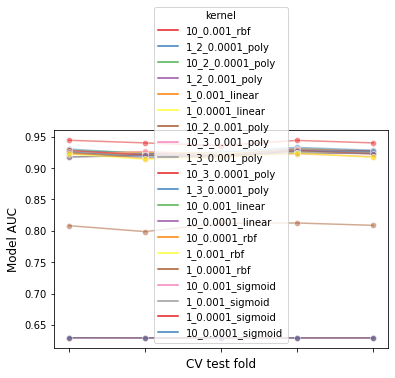

Correlation of models:
 kernel             10_0.001_rbf  1_2_0.0001_poly  10_2_0.0001_poly  \
kernel                                                               
10_0.001_rbf           1.000000         0.726258          0.956208   
1_2_0.0001_poly        0.726258         1.000000          0.850115   
10_2_0.0001_poly       0.956208         0.850115          1.000000   
1_2_0.001_poly         0.718521         0.643094          0.743859   
1_0.001_linear         0.313251         0.208546          0.465864   
1_0.0001_linear        0.313251         0.208546          0.465864   
10_2_0.001_poly        0.558926         0.727449          0.748780   
10_3_0.001_poly        0.515846         0.274363          0.607130   
1_3_0.001_poly         0.785479         0.952205          0.921304   
10_3_0.0001_poly       0.989627         0.815248          0.973404   
1_3_0.0001_poly        0.733322         0.911856          0.815828   
10_0.001_linear        0.178743         0.398410          0.398561

In [35]:
model_scores = results_df.filter(regex=r'split\d*_test_score')

fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

Podemos observar que el rendimiento de los modelos depende en gran medida del pliegue.

# 7 Selección de Modelos

Por ultimo, quisieramos remarcar los modelos que han maximizado nuestra metrica objetivo, la **accuracy**.

Los dos modelos que mejor performance nos han reportado son los siguientes:

* Regresion logistica haciendo uso de la seleccion de features 1 y solver='newton-cg' (Accuracy 93%)
* SVM haciendo uso de  de la seleccion de features 1 y kernel='linear' (Accuracy 93%)

De modo que ambos modelos serian claros candidatos para su uso final.